## House Price Prediction for King County, USA

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

warnings.filterwarnings("ignore")

### Importing and Transforming Dataset

The information used in the dataset was obtained from <a href="https://www.kaggle.com/datasets/harlfoxem/housesalesprediction">House Sales in King County, USA</a> in Kaggle, which contains records of homes that were sold between May 2014 and May 2015. See the <a href="https://www.kaggle.com/datasets/harlfoxem/housesalesprediction/discussion/207885">field definition</a>.

In [183]:
kc_house_df = pd.read_csv('./Dataset/King County US House Data.csv')

print(f'No. of records: {kc_house_df.shape[0]}')
kc_house_df.head(5)

No. of records: 21613


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,6762700020,20141013T000000,7700000.0,6,8.00,12050,27600,2.5,0,3,...,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
1,9808700762,20140611T000000,7062500.0,5,4.50,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
2,9208900037,20140919T000000,6885000.0,6,7.75,9890,31374,2.0,0,4,...,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730
3,2470100110,20140804T000000,5570000.0,5,5.75,9200,35069,2.0,0,0,...,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345
4,8907500070,20150413T000000,5350000.0,5,5.00,8000,23985,2.0,0,4,...,12,6720,1280,2009,0,98004,47.6232,-122.220,4600,21750


Exclude any columns that are not required for analysis

In [184]:
kc_house_df_filtered = kc_house_df.drop(['id', 'date', 'zipcode'], axis=1)
kc_house_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21613 non-null  int64  
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  yr_renovated   21613 non-null  int64  
 14  lat            21613 non-null  float64
 15  long           21613 non-null  float64
 16  sqft_living15  21613 non-null  int64  
 17  sqft_lot15     21613 non-null  int64  
dtypes: flo

Check if there are missing values

In [185]:
kc_house_df_filtered.isna().sum().sort_values(ascending=False)

price            0
bedrooms         0
sqft_living15    0
long             0
lat              0
yr_renovated     0
yr_built         0
sqft_basement    0
sqft_above       0
grade            0
condition        0
view             0
waterfront       0
floors           0
sqft_lot         0
sqft_living      0
bathrooms        0
sqft_lot15       0
dtype: int64

Assuming that the all houses were listed for sale in 2016: The house's age can be determined by subtracting its `yr_built` from 2016. However, if the house underwent renovation, then its age will be calculated by subtracting its `yr_renovated` from 2016.

In [186]:
YEAR_HOUSE_SALE_POSTED = 2016
year_built = kc_house_df_filtered['yr_built']
year_renovated = kc_house_df_filtered['yr_renovated']

kc_house_df_filtered['house_age'] = np.where(year_renovated == 0, YEAR_HOUSE_SALE_POSTED - year_built, YEAR_HOUSE_SALE_POSTED - year_renovated)

kc_house_df_filtered = kc_house_df_filtered.drop(['yr_renovated', 'yr_built'], axis=1)

print(f'No. of records: {kc_house_df_filtered.shape[0]}')
kc_house_df_filtered.head(5)

No. of records: 21613


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,house_age
0,7700000.0,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,47.6298,-122.323,3940,8800,29
1,7062500.0,5,4.50,10040,37325,2.0,1,2,3,11,7680,2360,47.6500,-122.214,3930,25449,15
2,6885000.0,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,47.6305,-122.240,4540,42730,15
3,5570000.0,5,5.75,9200,35069,2.0,0,0,3,13,6200,3000,47.6289,-122.233,3560,24345,15
4,5350000.0,5,5.00,8000,23985,2.0,0,4,3,12,6720,1280,47.6232,-122.220,4600,21750,7


In [187]:
kc_house_df_filtered['house_age'].sort_index(ascending=True).unique()

array([ 29,  15,   7,  25,  17,  12,  13,   8,  36,  38,  19,  16,  80,
         9,  26,  11,  14,   2,   6,  62,  27, 112, 106,  21,  23,  20,
        10,  59, 107,  89,   3,  93,  90,  91,  22,  40,  88, 110,  31,
        43,  37,  41,   5,  75, 108,  53,  66,  55, 100,  78,  85,  24,
        94,  76,  81, 104, 109,  95,  47,  28,  54,  33,  86,  65, 111,
        39,  83,  64,  34, 105,  77,  49,  51,  45,  48,   4,   1, 114,
        57,  18,  56,  32, 102,  67,  35,  44,  79,  87,  74,  42,  92,
       116,  70,  50, 103,  52,  63,  30,  61, 101,  46,  68,  58,  60,
        97,  98,  69, 115,  84, 113,  96,  71,  99,  73,  72,  82],
      dtype=int64)

### Exploratory Data Analysis

Examine the distribution of the house parts columns (`bedrooms`, `bathrooms`, `floors` and `waterfront`) in the dataset.
- Remove any data points that are considered outliers
- Remove records that are not logical

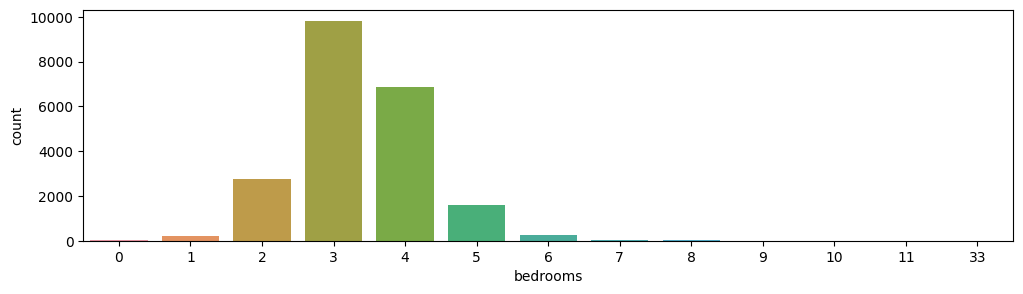

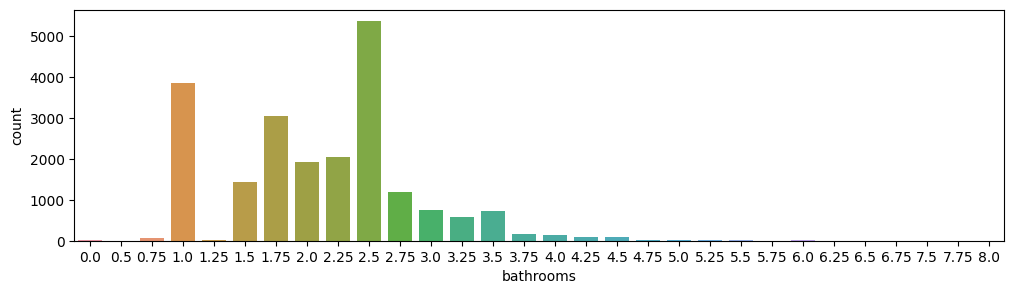

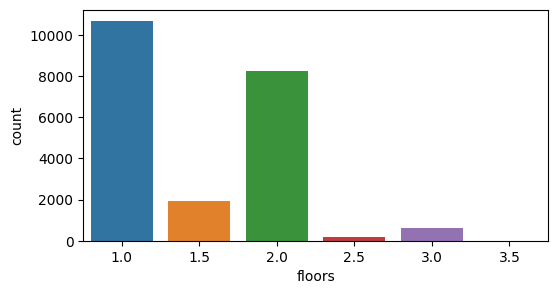

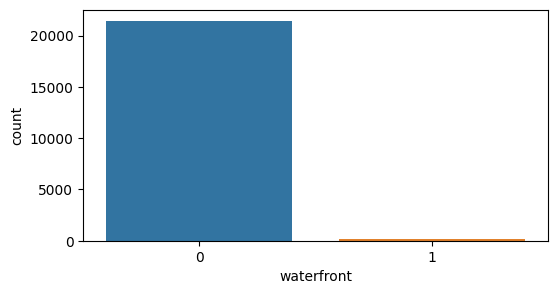

In [188]:
house_parts = ["bedrooms", "bathrooms" , "floors", "waterfront"]

for idx, part in enumerate(house_parts):
    if part in ['bedrooms', 'bathrooms']:
        plt.figure(figsize = (12,3))
    else:
        plt.figure(figsize = (6,3))
    sns.countplot(data=kc_house_df_filtered, x=part)

plt.show()

Remove the outlier record of the house with 33 bedrooms.

In [189]:
kc_house_df_filtered = kc_house_df_filtered.query('bedrooms <= 11')
kc_house_df_filtered['bedrooms'].value_counts().sort_index(ascending=True)

0       13
1      199
2     2760
3     9824
4     6882
5     1601
6      272
7       38
8       13
9        6
10       3
11       1
Name: bedrooms, dtype: int64

Remove the records that do not contain information about `bedrooms` and `bathrooms` since it doesn't make sense to sell a house lacking these features.

In [190]:
print(f'No. of records (before): {kc_house_df_filtered.shape[0]}')
kc_house_df_filtered = kc_house_df_filtered.query('bedrooms > 0 or bathrooms > 0')
print(f'No. of records (after): {kc_house_df_filtered.shape[0]}')

No. of records (before): 21612
No. of records (after): 21605


View summary statistics of numerical features and table information

In [191]:
print(f'No. of records: {kc_house_df_filtered.shape[0]}')
kc_house_df_filtered.describe().apply(lambda s: s.apply('{0:.2f}'.format))

No. of records: 21605


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,house_age
count,21605.00,21605.00,21605.00,21605.00,21605.00,21605.00,21605.00,21605.00,21605.00,21605.00,21605.00,21605.00,21605.00,21605.00,21605.00,21605.00,21605.00
mean,540089.91,3.37,2.12,2079.93,15108.96,1.49,0.01,0.23,3.41,7.66,1788.34,291.59,47.56,-122.21,1986.53,12768.89,42.61
std,367109.41,0.91,0.77,918.25,41427.70,0.54,0.09,0.77,0.65,1.17,827.82,442.62,0.14,0.14,685.18,27308.44,28.81
min,75000.00,0.00,0.00,370.00,520.00,1.00,0.00,0.00,1.00,3.00,370.00,0.00,47.16,-122.52,399.00,651.00,1.00
25%,322000.00,3.00,1.75,1427.00,5040.00,1.00,0.00,0.00,3.00,7.00,1190.00,0.00,47.47,-122.33,1490.00,5100.00,17.00
50%,450000.00,3.00,2.25,1910.00,7620.00,1.50,0.00,0.00,3.00,7.00,1560.00,0.00,47.57,-122.23,1840.00,7620.00,39.00
75%,645000.00,4.00,2.50,2550.00,10688.00,2.00,0.00,0.00,4.00,8.00,2210.00,560.00,47.68,-122.12,2360.00,10083.00,62.00
max,7700000.00,11.00,8.00,13540.00,1651359.00,3.50,1.00,4.00,5.00,13.00,9410.00,4820.00,47.78,-121.31,6210.00,871200.00,116.00


Display pairwise relationships between different variables in a dataset

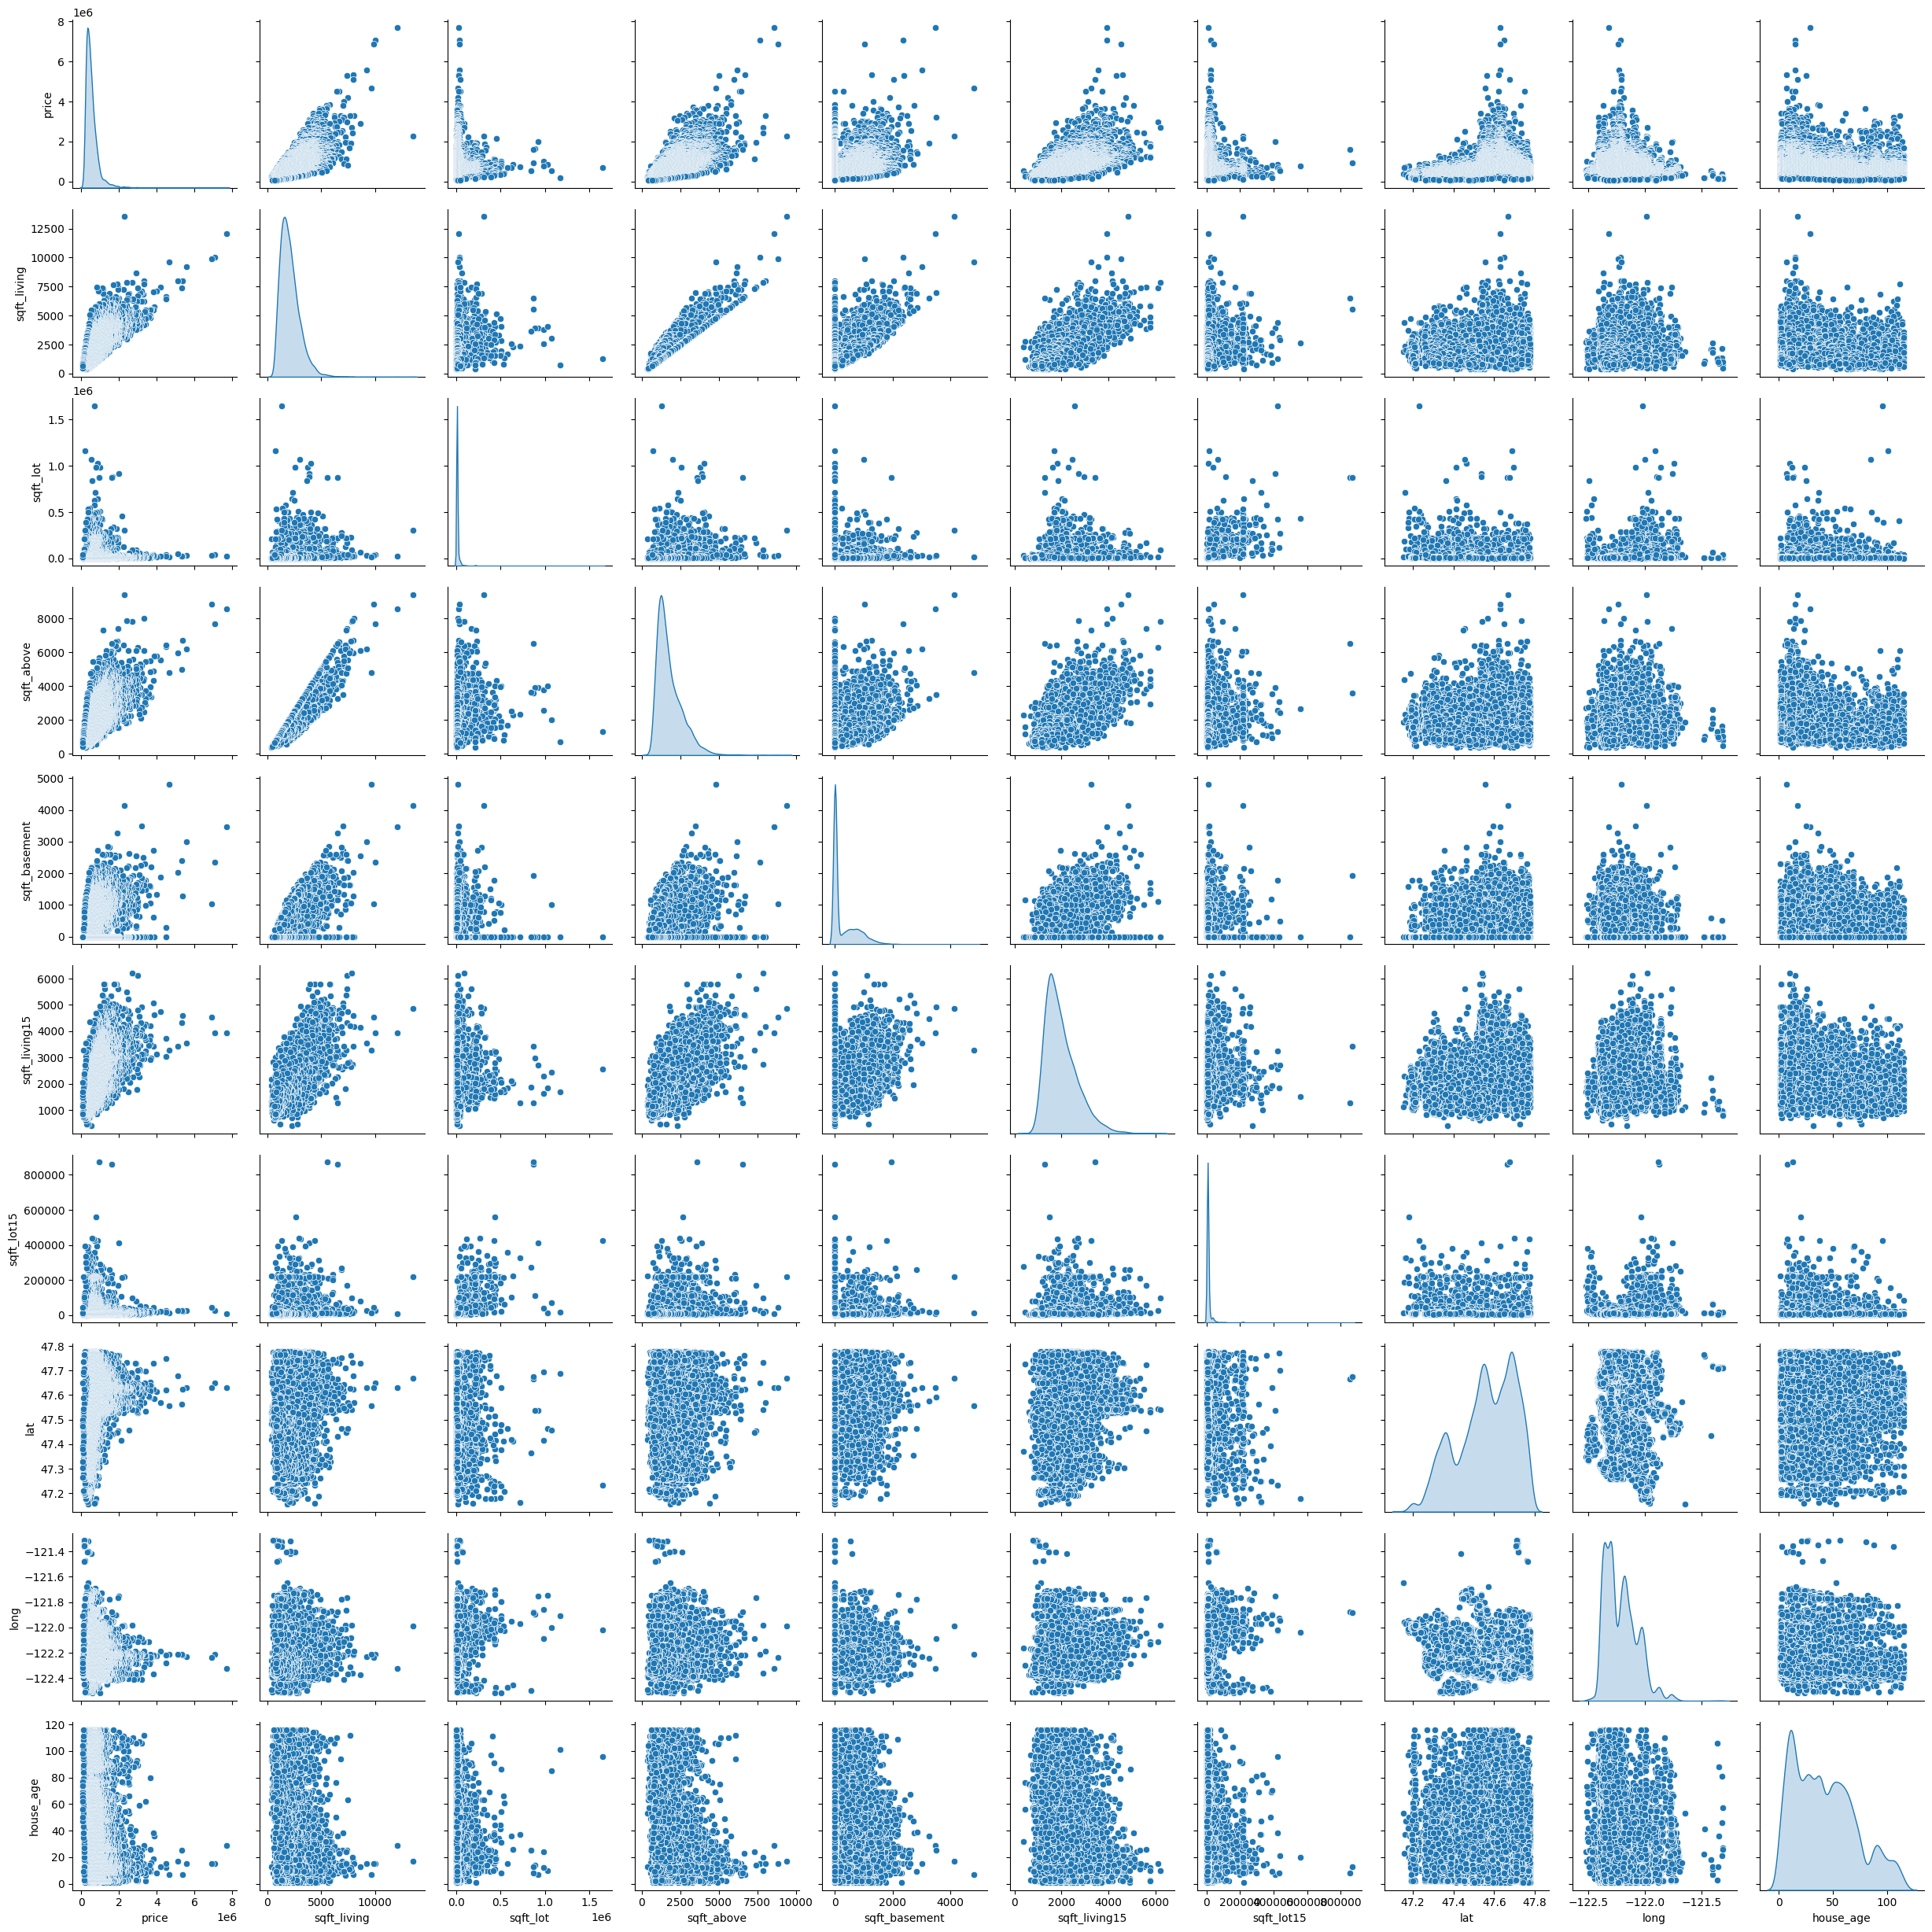

In [193]:
pp_features_df = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'lat', 'long', 'house_age']
sns.pairplot(data=kc_house_df_filtered[pp_features_df], diag_kind='kde')

#### Non-Parametric Correlation Analysis

Use the Spearman correlation to detect a monotonic relationship between the independent and dependent variables, meaning that the direction of the relationship is consistent but not necessarily linear.
- R ->  1   : Strong positive monotonic relationship
- R = 0     : No monotonic correlation
- R -> -1   : Strong negative monotonic relationship

Text(0.5, 1.0, 'Spearman Correlation Matrix')

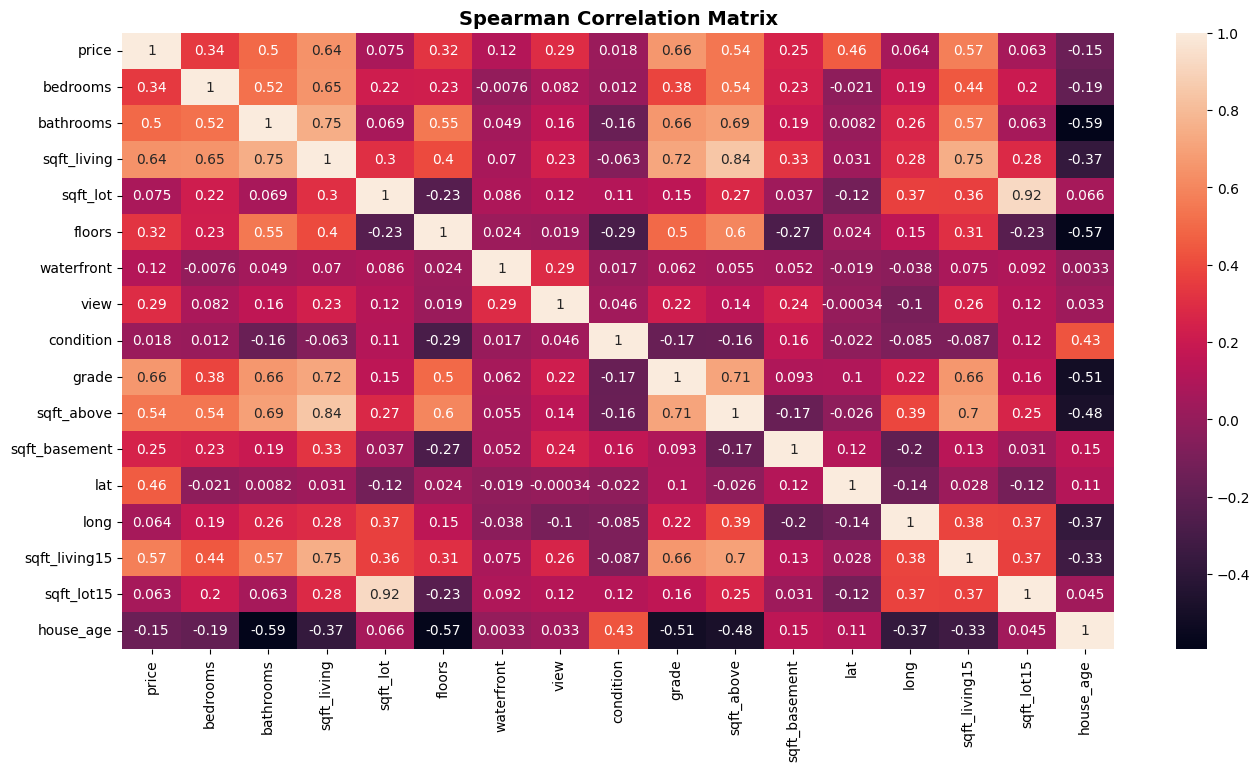

In [194]:
spearmancorr = kc_house_df_filtered.corr(method='spearman')

plt.figure(figsize = (16, 8))
sns.heatmap(spearmancorr, xticklabels=spearmancorr.columns, yticklabels=spearmancorr.columns, annot=True)
plt.title('Spearman Correlation Matrix', fontsize=14, fontweight='bold')

The degree of positive/negative correlation with the price of the house is presented below <sup>[9]</sup>
- __Very Strong (0.8 to 1.0):__ <em>none</em>
- __Strong (0.6 to .79):__ `grade`, `sqft_living`
- __Moderate (0.4 to 0.59):__ `bathrooms`, `lat`, `sqft_above`, `sqft_living15`
- __Weak (0.2 to 0.39):__ `bedrooms`, `floors`, `view`, `sqft_basement`
- __Very Weak (0.0 to 0.19):__ `waterfront`, `condition`, `long`, `sqft_lot`, `sqft_lot15`, `house_age`

#### Testing Null Hypothesis for Very Weak Predictors

The __p-value__ refers to the probability that the null hypothesis is true. It represents the probability that the relationship between x and y in the observed data happened by chance. In research, a p-value of 0.05 or lower is generally considered statistically significant and is denoted as the significance level α. <sup>[10]</sup>
- __p-value < significance level:__ reject the null hypothesis and conclude the correlation is statistically significant
- __p-value > significance level:__ fail to reject the null hypothesis and conclude that there is no significant correlation between x and y

As seen below, since p-value is less than the significance level (α=0.05), we can reject the null hypothesis and conclude that there is a monotonic correlation between the independent variables and the house price at the 0.05 level.

In [195]:
weak_correlation_features = ['waterfront', 'condition', 'long', 'sqft_lot', 'sqft_lot15', 'house_age']

weak_feature_df = pd.DataFrame()
correlation = []
p_value = []
for feature in weak_correlation_features:
    # compute Spearman correlation and p-value
    corr, pval = spearmanr(kc_house_df_filtered[feature], kc_house_df_filtered['price'])
    correlation.append(round(corr, 2))
    p_value.append(round(pval, 4))

weak_feature_df['feature'] = weak_correlation_features
weak_feature_df['spearman correlation'] = correlation
weak_feature_df['spearman p-value'] = p_value

weak_feature_df.head()

,feature,spearman correlation,spearman p-value
0,waterfront,0.12,0.0000
1,condition,0.02,0.0069
2,long,0.06,0.0000
3,sqft_lot,0.07,0.0000
4,sqft_lot15,0.06,0.0000


### Splitting Data into Training and Test Set

In [196]:
X_features = kc_house_df_filtered.drop(['price'], axis=1)
y_feature = kc_house_df_filtered['price']

X_train, X_test, y_train, y_test = train_test_split(X_features, y_feature, test_size=0.2, random_state=0)

print(f"No. of train datasets: x={X_train.shape} y={y_train.shape}")
print(f"No. of test datasets: x={X_test.shape} y={y_test.shape}")

No. of train datasets: x=(17284, 16) y=(17284,)
No. of test datasets: x=(4321, 16) y=(4321,)


### Creating a Model

We have decided to use Polynomial Regression in our model as there is a non-linear correlation between some of the independent variables and the dependent variable (house price). However, due to memory limitations when processing data with a polynomial degree greater than 2, we can only train and test our model using degree 2.

In [197]:
poly = PolynomialFeatures(degree=2)
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

model = LinearRegression()
model.fit(X_train, y_train)

print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")

Intercept: -602501065.406096
Coefficients: [ 1.67998499e+03  1.37207234e+07 -6.65619161e+06  4.68846868e+04
  9.85447918e+01  6.94856244e+06  6.76136545e+07  2.43530697e+05
  3.63229838e+06 -2.04648614e+07 -8.37382423e+04 -8.35889385e+04
  1.03782883e+08  2.90406173e+07 -1.98528427e+04  3.00941522e+02
 -6.08346957e+05  2.15927907e+03 -5.60503023e+02 -2.28798381e+02
 -4.80247829e-02  1.95395326e+04 -8.06064872e+04  5.40538341e+03
 -4.91410114e+03  3.94278011e+03  2.00409034e+02  2.05096498e+02
 -2.16110359e+04  1.04164594e+05  1.01222356e+01  1.38278412e-01
  3.51900076e+02 -9.76583591e+03  2.00006260e+01 -4.68338837e-01
 -2.38253814e+04  9.28069977e+04  7.36204365e+03 -9.82774072e+03
  1.28450468e+04  2.56806496e+01 -1.01133640e+01  5.75619275e+04
 -3.18474944e+04 -1.51885198e+01  3.05849445e-01  1.34701263e+02
  1.81452482e+03 -5.17243673e+01 -2.18456385e+01  1.59654031e+02
 -1.78806916e+01  1.65707237e+01  1.21361378e+01  2.78248660e+03
 -2.58888989e+03  1.70489418e+02 -1.70304139e+0

### Evaluating the Model

The model's score for the train dataset is <b>0.8044</b> and test dataset is <b>0.809</b>, indicating a relatively good performance in predicting house prices in King County, USA.

In [198]:
print(f"Model Score Train: {round(model.score(X_train, y_train), 4)}") 
print(f"Model Score Test: {round(model.score(X_test, y_test), 4)}")

Model Score Train: 0.8044
Model Score Test: 0.809


The graph below shows the scatterplot of the relationship between the actual and predicted house prices. 

[Text(0.5, 0, 'Actual House Price'),
 Text(0, 0.5, 'Predicted House Price'),
 Text(0.5, 1.0, 'Predicted House Prices vs. Actual House Prices')]

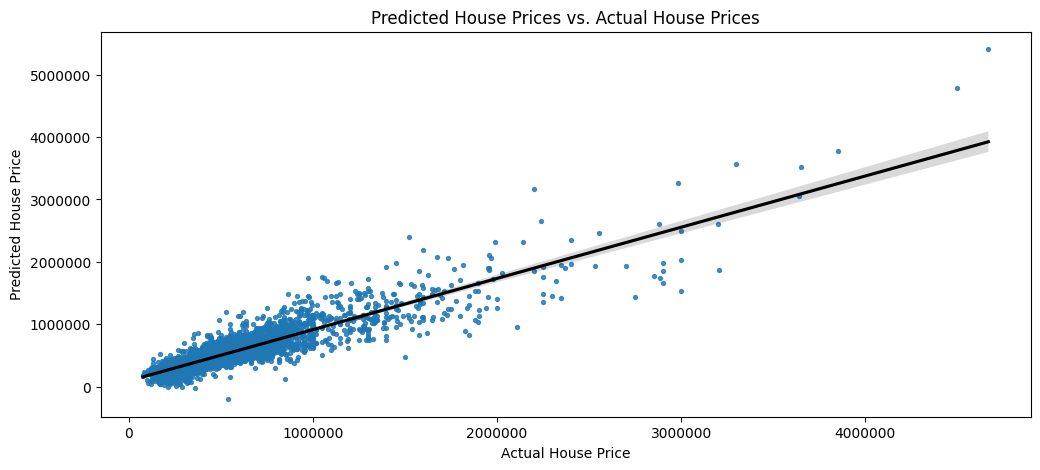

In [199]:
y_predict = model.predict(X_test)

plt.figure(figsize=(12, 5))
plt.ticklabel_format(style='plain')
ax = sns.regplot(x=y_test, y=y_predict, line_kws={"color": "black"}, scatter_kws={'s': 8})
ax.set(xlabel ="Actual House Price", ylabel = "Predicted House Price", title="Predicted House Prices vs. Actual House Prices")

The residuals of house prices are normally distributed around zero (0), which is a positive indicator. However, there are few records with high residual, which need further analysis.


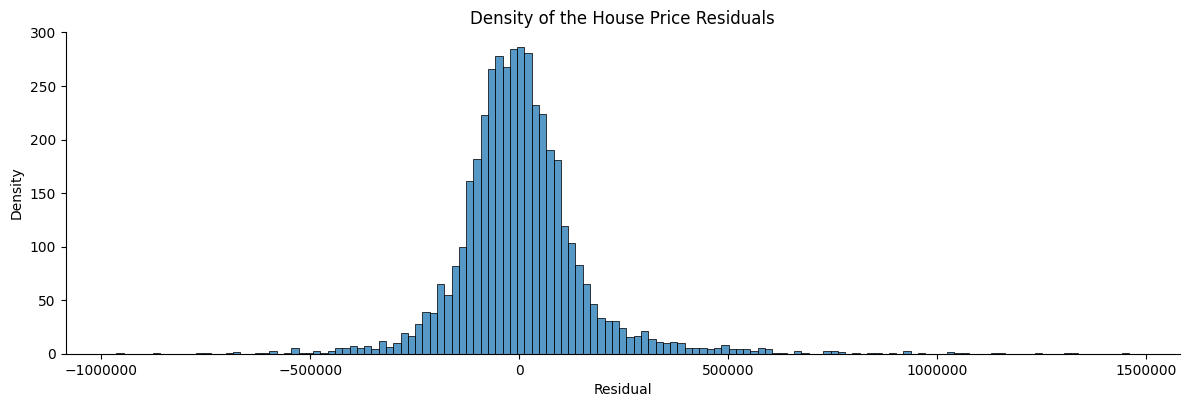

In [200]:
residual = y_test - y_predict

ax = sns.displot(residual, kind='hist', height=4, aspect=3)
ax.set(xlabel ="Residual", ylabel = "Density", title ='Density of the House Price Residuals')

plt.ticklabel_format(style='plain', axis='x')

The <b>R-squared (R<sup>2</sup>) of the model is 0.81</b>, which indicates that the model is able to capture most of the variation in the house price.

NOTE: R<sup>2</sup> value ranges from 0 to 1. A higher value indicates a better fit of the model to the data.

In [201]:
r2 = r2_score(y_test, y_predict)
print(f"R-squared (R2): {round(r2, 2)}")

R-squared (R2): 0.81


The following are other metrics to evaluate the performance of the model.
- __Mean Absolute Error (MAE)__ measures the average absolute difference between the predicted and actual values of the dependent variable.
- __Mean Squared Error (MSE)__ measures the average of the squared differences between the predicted and actual values of the dependent variable.
- __Root Mean Squared Error (RMSE)__ is the square root of the MSE and measures the average magnitude of the errors between the predicted and actual values.

In [202]:
mae = mean_absolute_error(y_test, y_predict)
print(f"Mean Absolute Error (MAE): {round(mae, 2)}")

mse = mean_squared_error(y_test, y_predict)
print(f"Mean Squared Error (MSE): {round(mse, 2)}")

rmse = mean_squared_error(y_test, y_predict, squared=False)
print(f"Root Mean Squared Error (RMSE): {round(rmse, 2)}")

Mean Absolute Error (MAE): 104122.87
Mean Squared Error (MSE): 25672222938.68
Root Mean Squared Error (RMSE): 160225.54


### Making Test Prediction

We will evaluate our model by utilizing it to estimate the price of the houses in King County, USA given the features.

In [203]:
from enum import Enum

class Feature(Enum):

    Bedrooms = 0
    Bathrooms = 1
    SqFtLiving = 2
    SqFtLot = 3
    Floors = 4
    Waterfront = 5
    View = 6
    Condition = 7
    Grade = 8
    SqFtAbove = 9  
    SqFtBasement = 10
    Latitude = 11
    Longitude = 12
    SqFtLiving15 = 13
    SqFtLot15 = 14
    HouseAge = 15


def getPrediction(input_data):
    df = np.array(input_data).reshape(1,-1)
    df = poly.transform(df)
    return model.predict(df)[0]


def testPrediction(input_data):

    print("------------------------------------------------------------------")
    print("                           HOUSE FEATURES                         ")
    print("------------------------------------------------------------------")
    for key, value in input_data.items():
        print(f"{key}: {value}")
    print("------------------------------------------------------------------")
    
    upd_input_data = [0] * (kc_house_df_filtered.columns.size - 1)

    upd_input_data[Feature.Bedrooms.value] = np.floor(input_data['Number of bedrooms'])
    upd_input_data[Feature.Bathrooms.value] = np.floor(input_data['Number of bathrooms'])
    upd_input_data[Feature.Floors.value] = np.floor(input_data['Number of floors'])
    upd_input_data[Feature.Waterfront.value] = 1 if input_data['Is overlooking the waterfront?'].lower() == 'yes' else 0
    
    upd_input_data[Feature.View.value] = input_data['View (rate from 1 to 4)']
    upd_input_data[Feature.Condition.value] = input_data['Condition (rate from 1 to 5)']
    upd_input_data[Feature.Grade.value] = input_data['Grade of construction and design (1-13)']

    upd_input_data[Feature.SqFtLot.value] = input_data['Land space (sq.ft.)']
    upd_input_data[Feature.SqFtLiving.value] = input_data['Interior living space (sq.ft.)']
    upd_input_data[Feature.SqFtAbove.value] = input_data['Interior housing space above ground level (sq.ft)']
    upd_input_data[Feature.SqFtBasement.value] = input_data['Interior housing space below ground level (sq.ft)']
    upd_input_data[Feature.SqFtLot15.value] = input_data['Land space of the nearest 15 neighbor']
    upd_input_data[Feature.SqFtLiving15.value] = input_data['Interior housing living space for the nearest 15 neighbors']

    upd_input_data[Feature.Latitude.value] = input_data['Latitude']
    upd_input_data[Feature.Longitude.value] = input_data['Longitude']

    year_built = input_data['Year the house was built']
    year_renovation = input_data['Year the house was renovated']
    upd_input_data[Feature.HouseAge.value] = (YEAR_HOUSE_SALE_POSTED - year_built) if year_renovation == 0 else (YEAR_HOUSE_SALE_POSTED - year_renovation)


    prediction = getPrediction(upd_input_data)

    print("\nActual price of the house: {:.2f}".format(input_data['Actual Price']))
    print("Predicted price of the house: {:.2f}".format(prediction))

__Test data #1__

In [204]:
input_data = {
    'Actual Price' : 3400000,
    'Number of bedrooms' : 4,
    'Number of bathrooms' : 4,
    'Number of floors' : 2,
    'Is overlooking the waterfront?' : 'Yes',
    'Year the house was built' : 1937,
    'Year the house was renovated' : 2010,
    'View (rate from 1 to 4)' : 0,
    'Condition (rate from 1 to 5)' : 3,
    'Grade of construction and design (1-13)' : 11,
    'Land space (sq.ft.)' : 11765,
    'Interior living space (sq.ft.)' : 4260,
    'Interior housing space above ground level (sq.ft)' : 3280,
    'Interior housing space below ground level (sq.ft)' : 980,
    'Latitude' : 47.638,
    'Longitude' : -122.288,
    'Land space of the nearest 15 neighbor' : 4260,
    'Interior housing living space for the nearest 15 neighbors' : 10408
}

testPrediction(input_data)

------------------------------------------------------------------
                           HOUSE FEATURES                         
------------------------------------------------------------------
Actual Price: 3400000
Number of bedrooms: 4
Number of bathrooms: 4
Number of floors: 2
Is overlooking the waterfront?: Yes
Year the house was built: 1937
Year the house was renovated: 2010
View (rate from 1 to 4): 0
Condition (rate from 1 to 5): 3
Grade of construction and design (1-13): 11
Land space (sq.ft.): 11765
Interior living space (sq.ft.): 4260
Interior housing space above ground level (sq.ft): 3280
Interior housing space below ground level (sq.ft): 980
Latitude: 47.638
Longitude: -122.288
Land space of the nearest 15 neighbor: 4260
Interior housing living space for the nearest 15 neighbors: 10408
------------------------------------------------------------------

Actual price of the house: 3400000.00
Predicted price of the house: 4171972.53


__Test data #2__

In [205]:
input_data = {
    'Actual Price' : 5110800,
    'Number of bedrooms' : 5,
    'Number of bathrooms' : 5,
    'Number of floors' : 2,
    'Is overlooking the waterfront?' : 'Yes',
    'Year the house was built' :1999,
    'Year the house was renovated' : 0,
    'View (rate from 1 to 4)' : 4,
    'Condition (rate from 1 to 5)' : 3,
    'Grade of construction and design (1-13)' : 12,
    'Land space (sq.ft.)' : 45517,
    'Interior living space (sq.ft.)' : 8010,
    'Interior housing space above ground level (sq.ft)' : 5990,
    'Interior housing space below ground level (sq.ft)' : 2020,
    'Latitude' : 47.6767,
    'Longitude' : -122.211,
    'Land space of the nearest 15 neighbor' : 26788,
    'Interior housing living space for the nearest 15 neighbors' : 3430
}

testPrediction(input_data)

------------------------------------------------------------------
                           HOUSE FEATURES                         
------------------------------------------------------------------
Actual Price: 5110800
Number of bedrooms: 5
Number of bathrooms: 5
Number of floors: 2
Is overlooking the waterfront?: Yes
Year the house was built: 1999
Year the house was renovated: 0
View (rate from 1 to 4): 4
Condition (rate from 1 to 5): 3
Grade of construction and design (1-13): 12
Land space (sq.ft.): 45517
Interior living space (sq.ft.): 8010
Interior housing space above ground level (sq.ft): 5990
Interior housing space below ground level (sq.ft): 2020
Latitude: 47.6767
Longitude: -122.211
Land space of the nearest 15 neighbor: 26788
Interior housing living space for the nearest 15 neighbors: 3430
------------------------------------------------------------------

Actual price of the house: 5110800.00
Predicted price of the house: 4958755.45


__Test data #3__

In [206]:
input_data = {
    'Actual Price' : 1095000,
    'Number of bedrooms' : 0,
    'Number of bathrooms' : 0,
    'Number of floors' : 3,
    'Is overlooking the waterfront?' : 'Yes',
    'Year the house was built' :1999,
    'Year the house was renovated' : 0,
    'View (rate from 1 to 4)' : 2,
    'Condition (rate from 1 to 5)' : 3,
    'Grade of construction and design (1-13)' : 7,
    'Land space (sq.ft.)' : 4764,
    'Interior living space (sq.ft.)' : 3064,
    'Interior housing space above ground level (sq.ft)' : 3064,
    'Interior housing space below ground level (sq.ft)' : 0,
    'Latitude' : 47.636,
    'Longitude' : -122.32,
    'Land space of the nearest 15 neighbor' : 4000,
    'Interior housing living space for the nearest 15 neighbors' : 2360
}

testPrediction(input_data)

------------------------------------------------------------------
                           HOUSE FEATURES                         
------------------------------------------------------------------
Actual Price: 1095000
Number of bedrooms: 0
Number of bathrooms: 0
Number of floors: 3
Is overlooking the waterfront?: Yes
Year the house was built: 1999
Year the house was renovated: 0
View (rate from 1 to 4): 2
Condition (rate from 1 to 5): 3
Grade of construction and design (1-13): 7
Land space (sq.ft.): 4764
Interior living space (sq.ft.): 3064
Interior housing space above ground level (sq.ft): 3064
Interior housing space below ground level (sq.ft): 0
Latitude: 47.636
Longitude: -122.32
Land space of the nearest 15 neighbor: 4000
Interior housing living space for the nearest 15 neighbors: 2360
------------------------------------------------------------------

Actual price of the house: 1095000.00
Predicted price of the house: 1229465.65


### Conclusions
- A Polynomial Regression algorithm with degree 2 is used to train and test a model that predicts house prices in King County, USA. The model yields scores of 0.8044 and 0.809 for train and test datasets respectively, which is an indication of good performance.
- The model has an R-squared (R<sup>2</sup>) of 0.81, which indicates that the model is able to capture most of the variation in the house price.
- The residuals of the house prices are normally distributed around zero (0), which is a positive indicator. However, there is a need for further analysis of a few instances with high residual values. The model's performance could be enhanced by including additional data, especially from high-value properties.

### Assumptions
- All houses were listed for sale in 2016 since the dataset was posted in Kaggle in the said year.
- We detected an outlier for house with a bedroom count of 33, and removed the record from the dataset.
- As it is irrational for a house to have no bedrooms or bathrooms, all data entries that do not include these features were removed.

### References

1. https://www.kaggle.com/datasets/harlfoxem/housesalesprediction
2. https://towardsdatascience.com/polynomial-regression-bbe8b9d97491
3. https://towardsdatascience.com/how-to-improve-the-accuracy-of-a-regression-model-3517accf8604
4. https://medium.com/bitgrit-data-science-publication/10-tips-to-improve-your-regression-modeling-f1af297c505a
5. https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9
6. https://towardsdatascience.com/the-complete-guide-to-linear-regression-in-python-3d3f8f06bf8 
7. https://www.mishrark.com/machine-learning/3-regression/simple-linear-regression-in-python
8. https://towardsdatascience.com/clearly-explained-pearson-v-s-spearman-correlation-coefficient-ada2f473b8
9. https://www.statstutor.ac.uk/resources/uploaded/spearmans.pdf
10. https://towardsdatascience.com/eveything-you-need-to-know-about-interpreting-correlations-2c485841c0b8


> BDM-1034 Winter 2023 Mid-Term Project (Group 7)